# Test Delight Learn 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : June  18th 2021
- Update June 23th 2021 : Covariance Matrix with redshifts
- update July 14th 2021 : Simple plots for LOR
- last update September 11th 2021 : Covariance matrix with filters


- **kernel : anaconda3pbs** @ CC

In [121]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [122]:
from matplotlib.colors import LogNorm

In [123]:
from mpi4py import MPI
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [124]:
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s, %(name)s[%(process)d] %(levelname)s %(message)s')

In [125]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [126]:
%matplotlib inline

# Configuration

- select if want to control Delight internal simulation or DC2

In [127]:
FLAG_DC2=True

In [128]:
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
    flux_multiplicative_factor=1.
    flux_multiplicative_factor2=1.
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level
else:
    configfilename='tmpsim/parametersTest.cfg'
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

# Load config and data

In [129]:
params = parseParamFile(configfilename, verbose=False)


comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()


if threadNum == 0:
    logger.info("--- DELIGHT-LEARN ---")


2021-09-14 16:22:12,653 ipykernel_launcher.py, __main__[168] INFO --- DELIGHT-LEARN ---


In [130]:
# Read filter coefficients, compute normalization of filters
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
numBands = bandCoefAmplitudes.shape[0]

redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
sed_names = params['templates_names']
f_mod = readSEDs(params)

In [131]:
band_name=["u","g","r","i","z","y"]
the_coloredmaps=["Blues","Greens","Reds","Oranges","Greys","Purples"]

In [132]:
numBands

6

In [133]:
all_renormmodel=[]
all_fluxes=[]

# Learn

In [134]:
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))

msg= 'Number of Training Objects ' + str(numObjectsTraining)
logger.info(msg)


firstLine = int(threadNum * numObjectsTraining / numThreads)
lastLine = int(min(numObjectsTraining,(threadNum + 1) * numObjectsTraining / numThreads))
numLines = lastLine - firstLine

    
msg ='Thread ' +  str(threadNum) + ' , analyzes lines ' + str(firstLine) + ' , to ' + str(lastLine)
logger.info(msg)

DL = approx_DL()


/tmp/ipykernel_168/1585406643.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
2021-09-14 16:22:12,972 ipykernel_launcher.py, __main__[168] INFO Number of Training Objects 3755
2021-09-14 16:22:12,973 ipykernel_launcher.py, __main__[168] INFO Thread 0 , analyzes lines 0 , to 3755


## Templates Model

In [135]:
f_mod.shape

(8, 6)

# Gaussian Processes

In [136]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

### Parameters

In [137]:
lines_pos=params['lines_pos']
lines_pos

[6500.0, 5002.26, 3732.22]

In [138]:
lines_width=params['lines_width']
lines_width

[20.0, 20.0, 20.0, 20.0]

In [139]:
V_C=params['V_C']
V_C

0.1

In [140]:
V_L=params['V_L']
V_L

0.1

In [141]:
alpha_C=params['alpha_C']
alpha_C

1000.0

In [142]:
alpha_L=params['alpha_L']
alpha_L

100.0

### Redshift grid

Text(0.5, 1.0, 'Redshift grids')

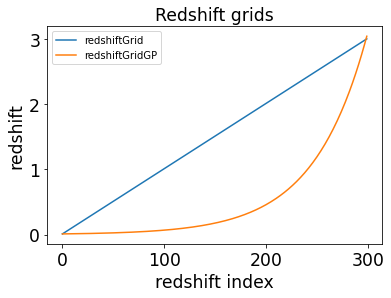

In [143]:
plt.plot(redshiftGrid,label="redshiftGrid")
plt.plot(redshiftGridGP,label="redshiftGridGP")
plt.xlabel("redshift index")
plt.ylabel("redshift")
plt.legend()
plt.title("Redshift grids")

# GP Average function

In [144]:
gp.mean_fct?

Type:           Photoz_linear_sed_basis
String form:    <delight.photoz_kernels.Photoz_linear_sed_basis object at 0x7f1f7fe97250>
File:           ~/.local/lib/python3.8/site-packages/delight/photoz_kernels.py
Docstring:     
Mean function of photoz GP, based on a library of templates.

Args:
    f_mod_interp: grid of interpolators of size (num templates, num bands)
        called as ``f_mod_interp[it, ib](z)``
Init docstring: Constructor.


In [145]:
X=np.zeros((numBands,3))
X[:,0]=np.arange(numBands)
X[:,1]=1.5
X[:,2]=1.0

In [146]:
gp.mean_fct.f(X).shape

(6, 8)

In [147]:
NBINS=20

## Make all X by varying z

In [148]:
all_F=[]
all_z=[]
all_X=[]
for z in np.linspace(0.1,3,NBINS):
    X=np.zeros((numBands,3))
    X[:,0]=np.arange(numBands)
    X[:,1]=z
    X[:,2]=1.0
    Fluxes=gp.mean_fct.f(X)
    all_F.append(Fluxes)
    all_z.append(z)
    all_X.append(X)
    

In [149]:
all_X[0].shape

(6, 3)

## Plotting

In [150]:
NR=2  
NC=3   
NT=8

### Select band and template

In [151]:
ib=1 # select band
it=0 # select template
F= [ f[ib,it] for f in all_F ]

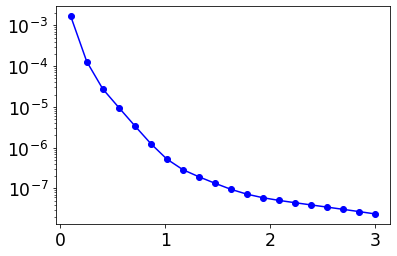

In [152]:
plt.plot(all_z,F,"o-b")
plt.yscale("log")

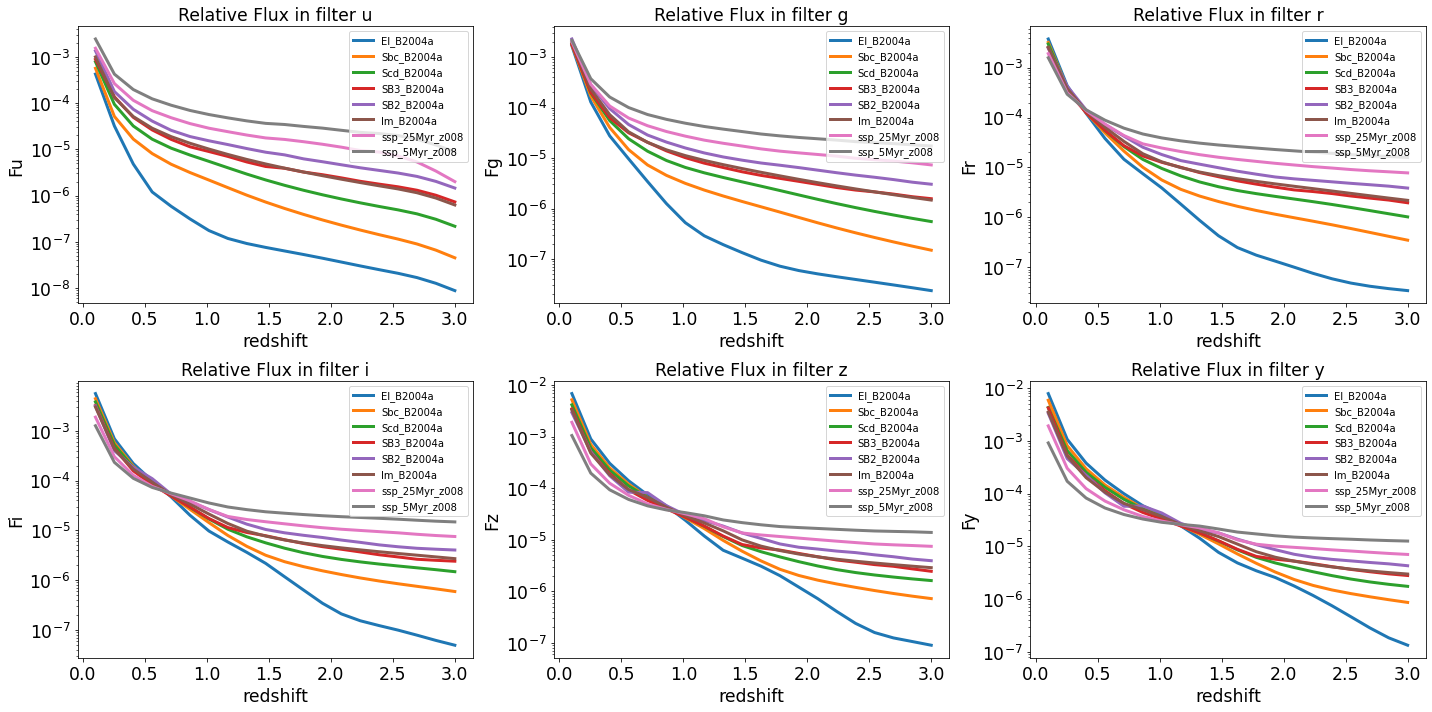

In [153]:
fig, axs = plt.subplots(NR, NC,figsize=(20,10))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib=ic+ir*NC
        
        for it in np.arange(NT):
            F= [ f[ib,it] for f in all_F]
            axs[ir,ic].plot(all_z,F,label=sed_names[it],lw=3)
            axs[ir,ic].set_yscale("log")
            axs[ir,ic].legend(loc="upper right")
            axs[ir,ic].set_xlabel("redshift")
            axs[ir,ic].set_ylabel("F"+band_name[ib])
            axs[ir,ic].set_title("Relative Flux in filter "+band_name[ib])
            
plt.tight_layout()
plt.show()

# GP Kernel

In [154]:
gp.kernel?

Type:           Photoz_kernel
String form:    <delight.photoz_kernels.Photoz_kernel object at 0x7f1f943a4640>
File:           ~/.local/lib/python3.8/site-packages/delight/photoz_kernels.py
Docstring:     
Photoz kernel based on RBF kernel in SED space.

Args:
    fcoefs_amp: ``numpy.array`` of size (numBands, numCoefs)
        describint the amplitudes of the Gaussians approximating the
        photometric filters.
    fcoefs_mu: ``numpy.array`` of size (numBands, numCoefs)
        describint the positions of the Gaussians approximating the
        photometric filters.
    fcoefs_sig: ``numpy.array`` of size (numBands, numCoefs)
        describint the widths of the Gaussians approximating the
        photometric filters.
    lines_mu: ``numpy.array`` of SED line positions
    lines_sig: ``numpy.array`` of SED line widths
    var_C: GP variance for SED continuum correlations.
        Should be a ``float`, preferably between 1e-3 and 1e2.
    var_L: GP variance for SED line correlations.

In [155]:
gp.kernel.g_AB

1.0

In [156]:
X1=np.zeros((numBands,3))
X1[:,0]=np.arange(numBands)
X1[:,1]=1
X1[:,2]=1.0

In [157]:
X2=np.zeros((numBands,3))
X2[:,0]=np.arange(numBands)
X2[:,2]=1
X2[:,2]=1.0

In [158]:
gp.kernel.K(X1,X2).shape

(6, 6)

## Covariance matrix

In [159]:
def Make_Covariance_Matrix(the_gp,all_X,ifilt1,ifilt2):
    """
    """
    N=len(all_X)
    
    K=np.zeros((N,N))
    
    for i in np.arange(N):
        X1=all_X[i]
        F1=np.average(the_gp.mean_fct.f(X1)[ifilt1])
        for j in np.arange(N):
           
            X2=all_X[j]
            F2=np.average(the_gp.mean_fct.f(X2)[ifilt2])
            K[i,j]=the_gp.kernel.K(X1,X2)[ifilt2,ifilt1]/(F1*F2)          
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            

In [160]:
def Make_Covariance_Matrix_nonorm(the_gp,all_X,ifilt1,ifilt2):
    """
    """
    N=len(all_X)
    
    K=np.zeros((N,N))
    
    for i in np.arange(N):
        X1=all_X[i]
        F1=np.average(the_gp.mean_fct.f(X1)[ifilt1])
        for j in np.arange(N):
           
            X2=all_X[j]
            F2=np.average(the_gp.mean_fct.f(X2)[ifilt2])
            K[i,j]=the_gp.kernel.K(X1,X2)[ifilt2,ifilt1]       
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            

In [161]:
def Make_Covariance_matrix_filters(the_gp,z1,z2):
    """
    """
    
    X1=np.zeros((numBands,3))
    X1[:,0]=np.arange(numBands)
    X1[:,1]=z1
    X1[:,2]=1
    
    Fluxes1=gp.mean_fct.f(X1)
    
    
    X2=np.zeros((numBands,3))
    X2[:,0]=np.arange(numBands)
    X2[:,1]=z2
    X2[:,2]=1
    
    Fluxes2=gp.mean_fct.f(X1)
    
    K=np.zeros((numBands,numBands))
    
    
    for ifilt1 in np.arange(numBands):
        F1=np.average(the_gp.mean_fct.f(X1)[ifilt1])
        for ifilt2 in np.arange(numBands):
           
            F2=np.average(the_gp.mean_fct.f(X2)[ifilt2])
            K[ifilt1,ifilt2]=the_gp.kernel.K(X1,X2)[ifilt1,ifilt2]/(F1*F2)          
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            
    


/tmp/ipykernel_168/1882460199.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_label_list)
/tmp/ipykernel_168/1882460199.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_label_list)
/tmp/ipykernel_168/1882460199.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_label_list)
/tmp/ipykernel_168/1882460199.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_label_list)


Text(0.5, 1.0, '$z_1$=1, $z_2$=2')

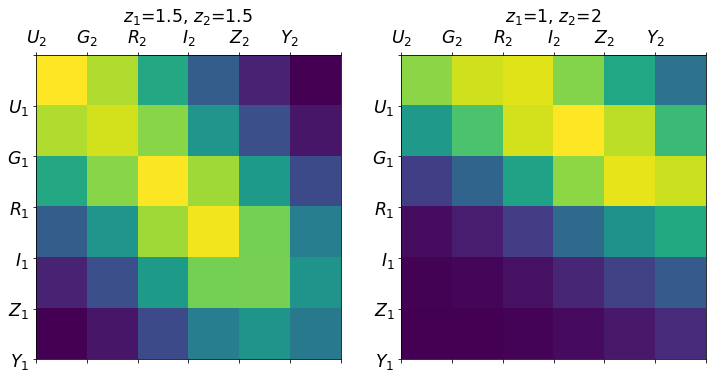

In [162]:
fig=plt.figure(figsize=(12,6))
               
ax=fig.add_subplot(1,2,1)

z1=1.5
z2=1.5
K=Make_Covariance_matrix_filters(gp,z1,z2)
#ax.matshow(K,cmap="jet",extent=(0,6,0,6))
ax.matshow(K,extent=(0,6,0,6))
x_label_list = ['$U_2$', '$G_2$', '$R_2$', '$I_2$', '$Z_2$', '$Y_2$' ]
y_label_list = ['$Y_1$', '$Z_1$', '$I_1$', '$R_1$', '$G_1$', '$U_1$' ]
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
title="$z_1$={}, $z_2$={}".format(z1,z2)
ax.set_title(title)

ax=fig.add_subplot(1,2,2)
z1=1
z2=2
K=Make_Covariance_matrix_filters(gp,z1,z2)
#ax.matshow(K,cmap="jet",extent=(0,6,0,6))
ax.matshow(K,extent=(0,6,0,6))

x_label_list = ['$U_2$', '$G_2$', '$R_2$', '$I_2$', '$Z_2$', '$Y_2$' ]
y_label_list = ['$Y_1$', '$Z_1$', '$I_1$', '$R_1$', '$G_1$', '$U_1$' ]

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
title="$z_1$={}, $z_2$={}".format(z1,z2)
ax.set_title(title)

#ax=fig.add_subplot(1,3,3)
#z1=0
#z2=3
#K=Make_Covariance_matrix_filters(gp,z1,z2)
#ax.matshow(K,cmap="jet",extent=(0,6,0,6))
#ax.matshow(K,extent=(0,6,0,6))
#x_label_list = ['$U_2$', '$G_2$', '$R_2$', '$I_2$', '$Z_2$', '$Y_2$' ]
#y_label_list = ['$Y_1$', '$Z_1$', '$I_1$', '$R_1$', '$G_1$', '$U_1$' ]
#ax.set_xticklabels(x_label_list)
#ax.set_yticklabels(y_label_list)
#title="$z_1$={}, $z_2$={}".format(z1,z2)
#ax.set_title(title)


### Plot covariance matrix

In [163]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]

In [164]:
NR=6  
NC=6   

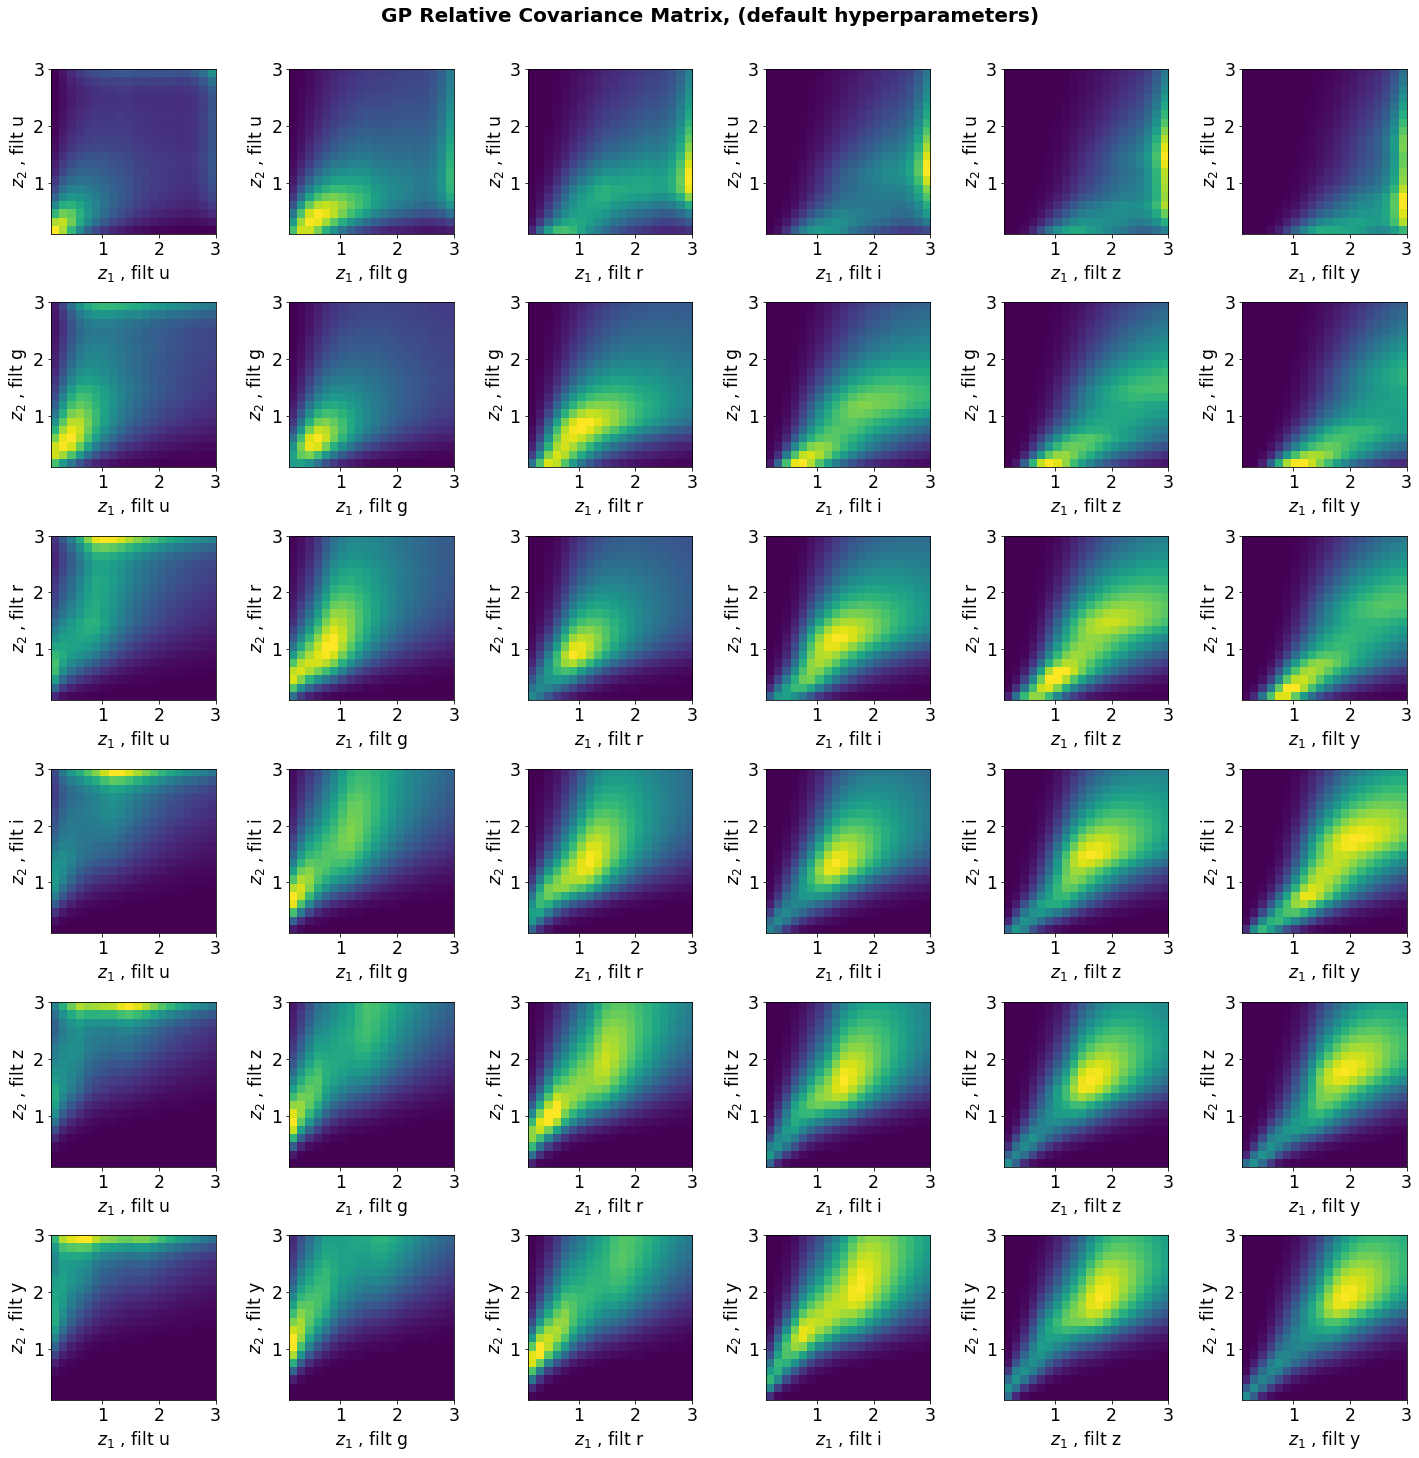

In [165]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        axs[ir,ic].imshow(Cov,origin="lower",extent=extent)
        axs[ir,ic].set_xlabel("$z_1$ , filt "+band_name[ib1])
        axs[ir,ic].set_ylabel("$z_2$ , filt "+band_name[ib2])
        
plt.suptitle("GP Relative Covariance Matrix, (default hyperparameters)",fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  
plt.show()

Text(0, 0.5, '$z_2$ , filt y')

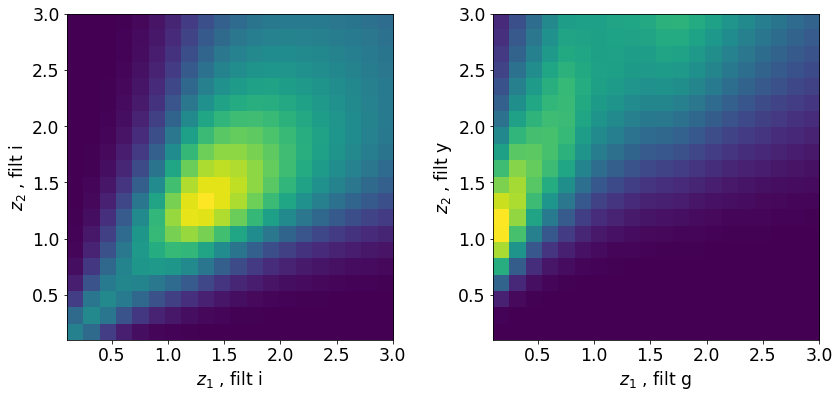

In [166]:
fig=plt.figure(figsize=(14,6))
               
ax=fig.add_subplot(1,2,1)
ib1=3
ib2=3
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
ax.imshow(Cov,origin="lower",extent=extent)
ax.set_xlabel("$z_1$ , filt "+band_name[ib1])
ax.set_ylabel("$z_2$ , filt "+band_name[ib2])
ax=fig.add_subplot(1,2,2)
ib1=1
ib2=5
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
ax.imshow(Cov,origin="lower",extent=extent)
ax.set_xlabel("$z_1$ , filt "+band_name[ib1])
ax.set_ylabel("$z_2$ , filt "+band_name[ib2])

# Generate random priors on Flux Function

In [167]:
ib=0 # select band
it=0 # select template
F= [ f[ib,it] for f in all_F ]

In [168]:
mu=np.zeros(NBINS)

In [169]:
C=Make_Covariance_Matrix_nonorm(gp,all_X,ib,5)

In [170]:
C.shape

(20, 20)

In [171]:
NSIM=20

In [172]:
F_gp  = np.random.multivariate_normal(mu, C, NSIM)

In [173]:
F_gp.shape

(20, 20)

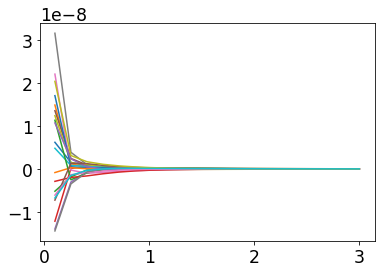

In [174]:
#plt.plot(all_z,F,"k-",lw=3)
for idx in np.arange(NSIM):
    plt.plot(all_z,F_gp[idx,:])
    
#plt.yscale("log")

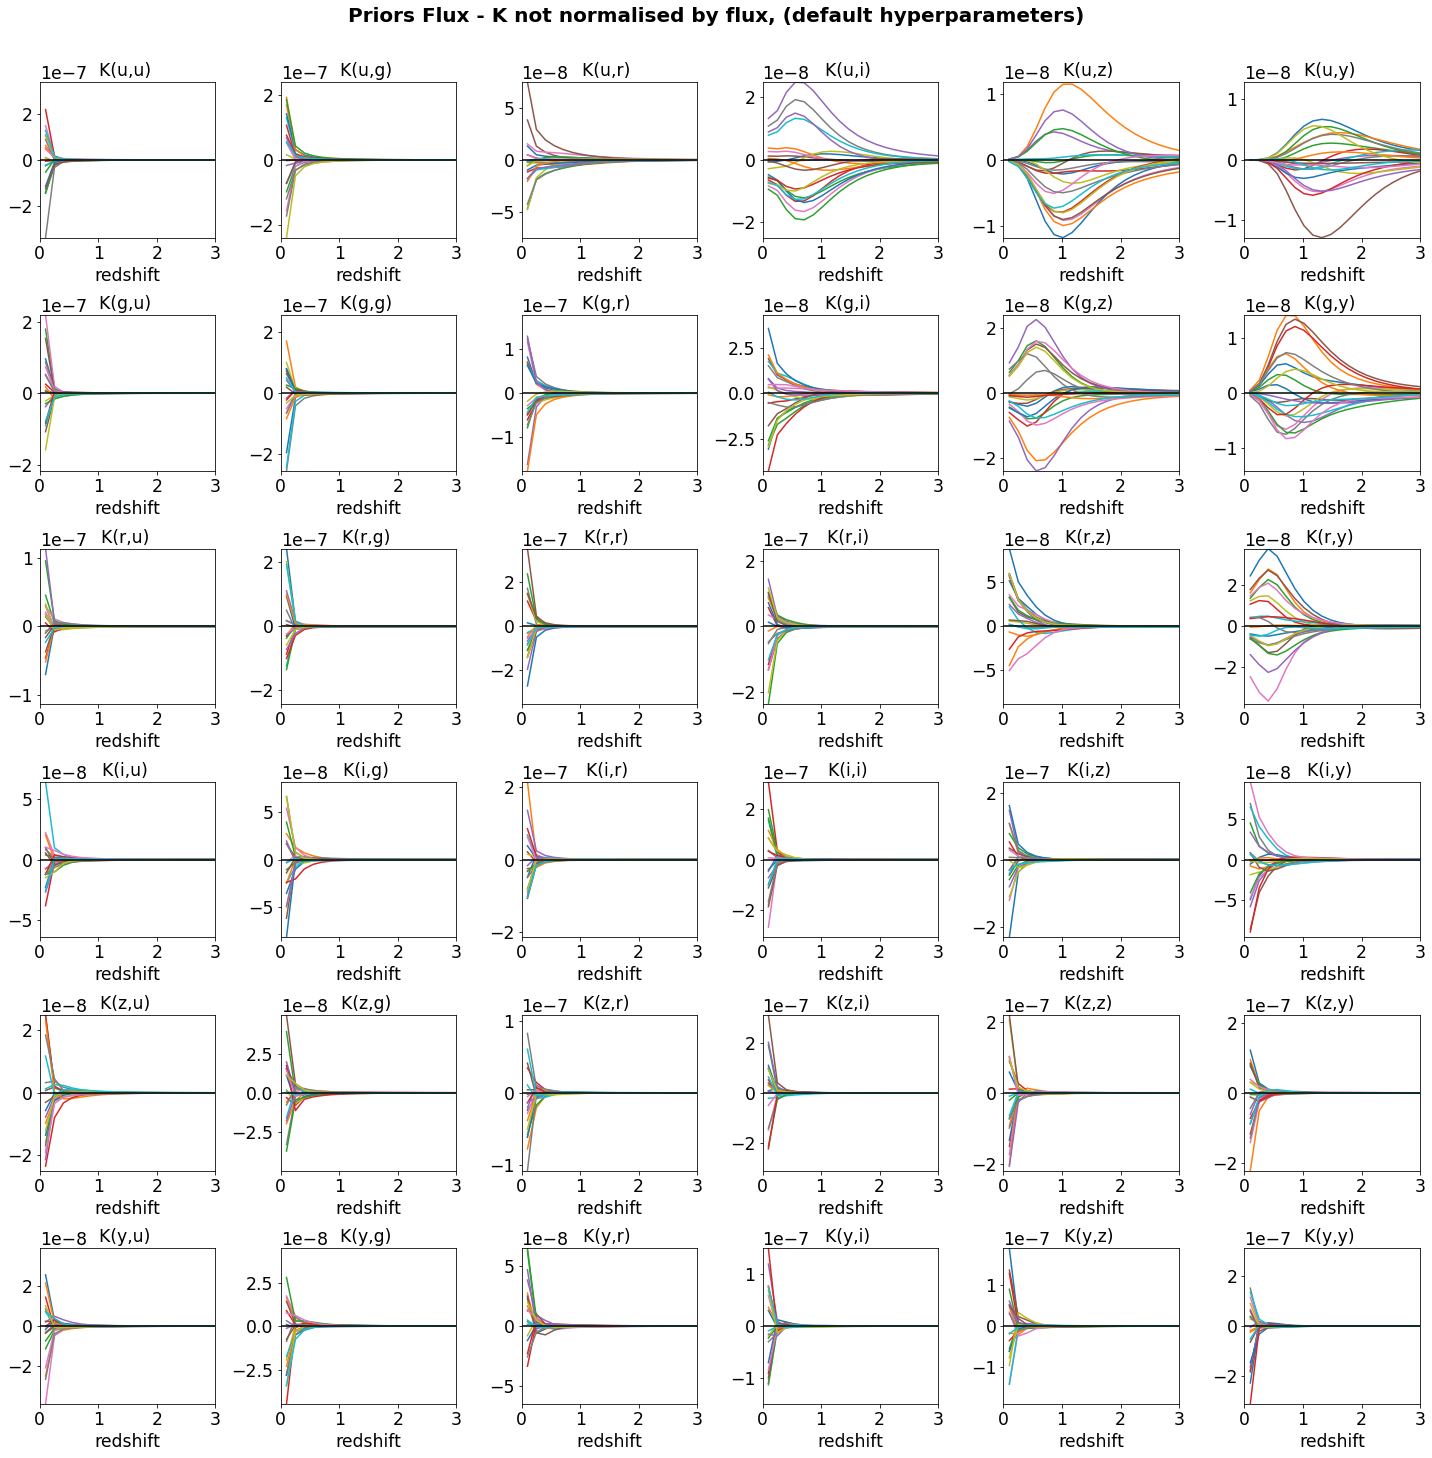

In [175]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix_nonorm(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color='k')
 
title = "Priors Flux - K not normalised by flux, (default hyperparameters)"
plt.suptitle(title,fontsize=20,y=1.01,fontweight="bold")
plt.tight_layout()      

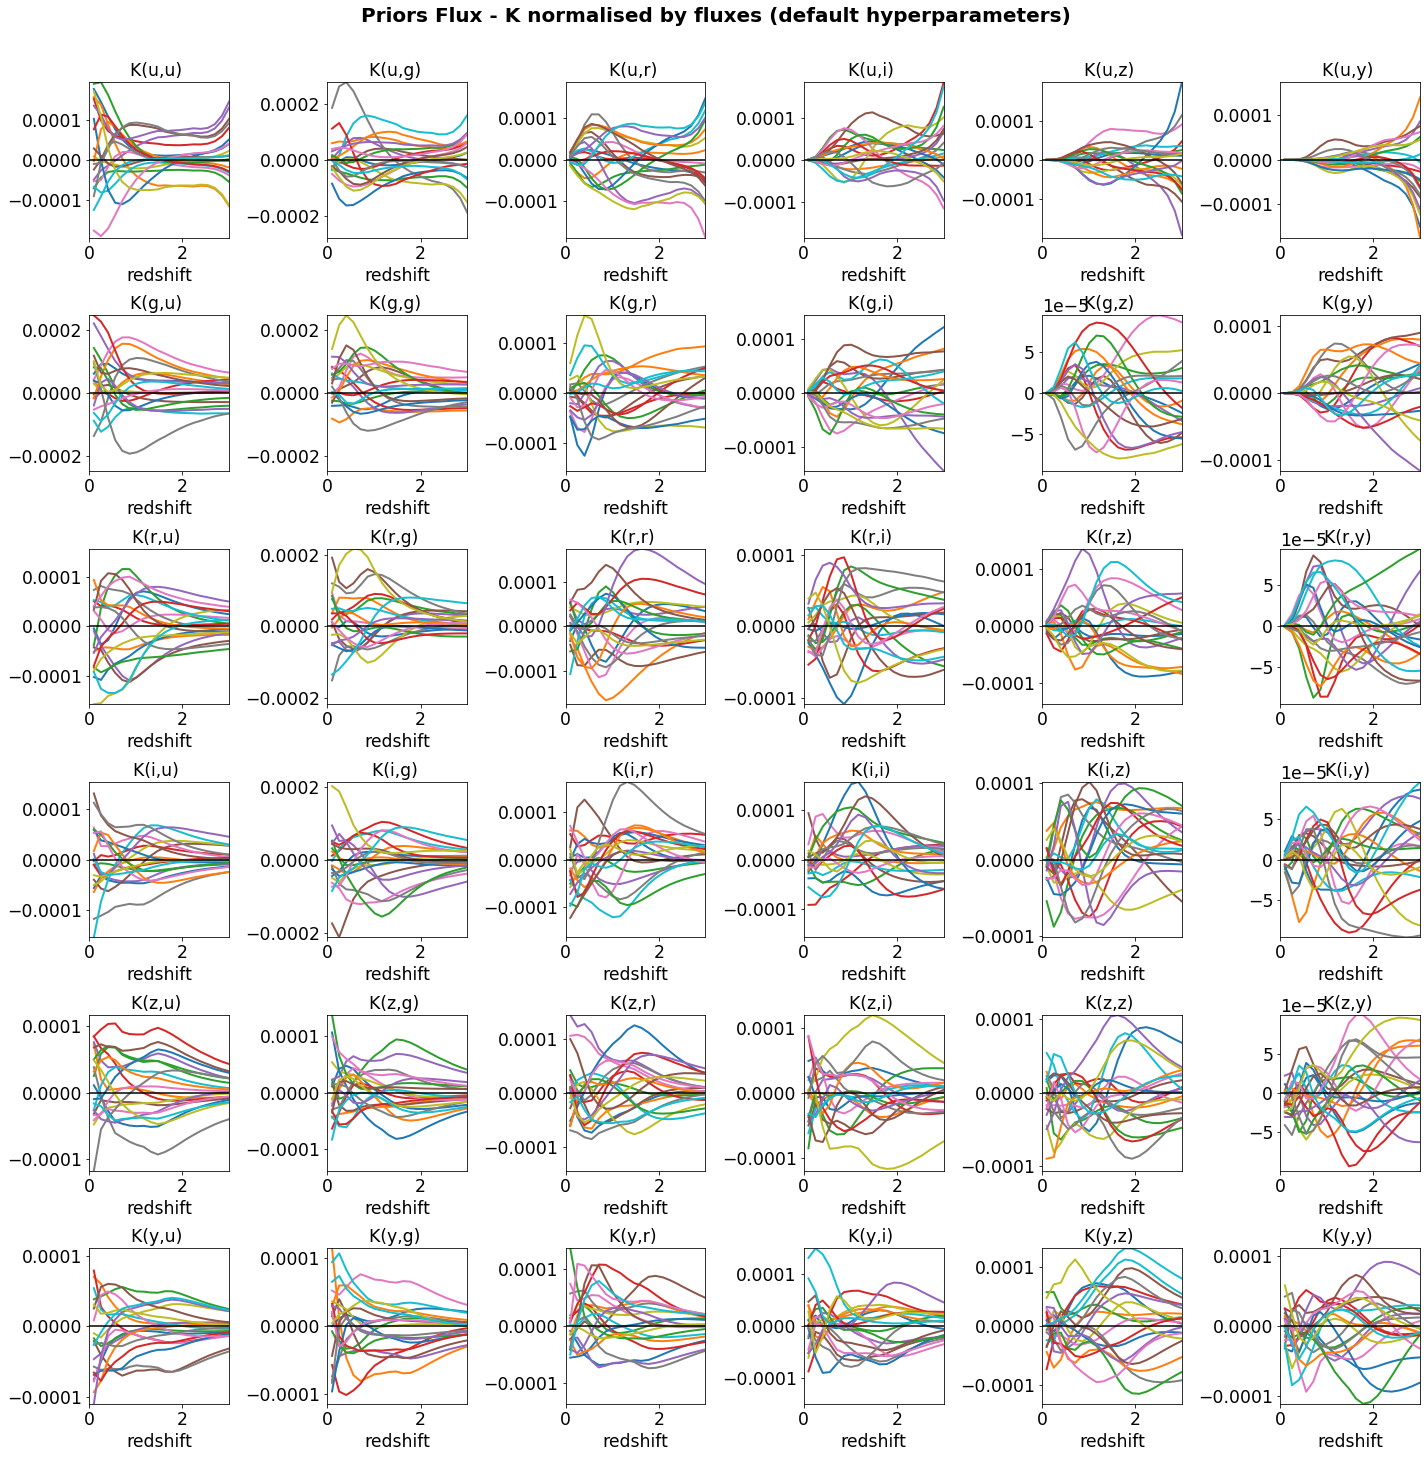

In [176]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:],lw=2)
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")

title="Priors Flux - K normalised by fluxes (default hyperparameters)"        
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()      

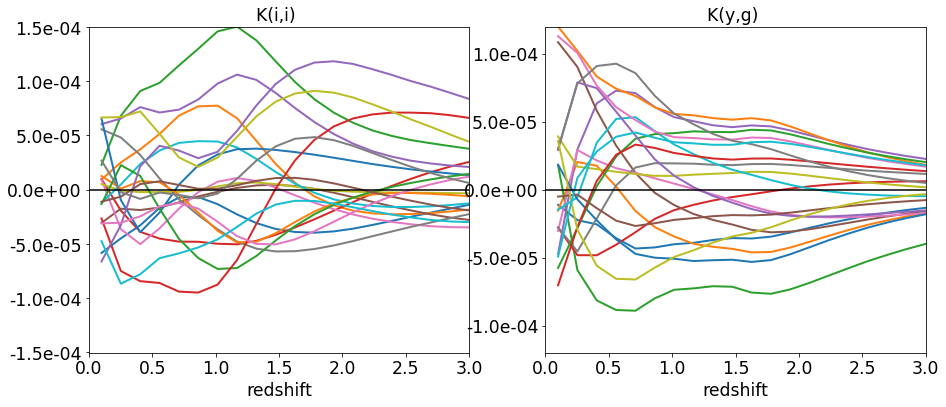

In [64]:
import matplotlib.ticker as ticker

fig=plt.figure(figsize=(15,6))
               
ax=fig.add_subplot(1,2,1)
ib1=3
ib2=3
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
F_gp_max=np.abs(F_gp).max()
for idx in np.arange(NSIM):
    ax.plot(all_z,F_gp[idx,:],lw=2)
ax.set_xlim(0,3)
ax.set_xlabel("redshift")
ax.set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
ax.set_ylim(-F_gp_max,F_gp_max)
ax.axhline(y=0,color="k")
# Rewrite the y labels
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1e'))


ax=fig.add_subplot(1,2,2)
ib1=1
ib2=5
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
F_gp_max=np.abs(F_gp).max()
for idx in np.arange(NSIM):
    ax.plot(all_z,F_gp[idx,:],lw=2)
ax.set_xlim(0,3)
ax.set_xlabel("redshift")
ax.set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
ax.set_ylim(-F_gp_max,F_gp_max)
ax.axhline(y=0,color="k")
# Rewrite the y labels
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1e'))

In [ ]:
alert False

## New parameters of Kernel 

In [ ]:
V_L

In [ ]:
V_L=10000

In [ ]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              lines_pos, lines_width,
              V_C, V_L,alpha_C, alpha_L,
              redshiftGridGP, use_interpolators=True)

In [ ]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        axs[ir,ic].imshow(Cov,origin="lower",extent=extent)
        axs[ir,ic].set_xlabel("$z_1$ , filt "+band_name[ib1])
        axs[ir,ic].set_ylabel("$z_2$ , filt "+band_name[ib2])
        
        
title="GP Relative Covariance Matrix, hyperparameters V_L={} (default V_L=0.1)".format(V_L)        
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  
plt.show()

In [ ]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:],lw=2)
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K normalised by fluxes, V_L={}".format(V_L)      
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()    

In [ ]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix_nonorm(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K not normalised by flux, V_L={}".format(V_L)
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()   

In [ ]:
V_C=1000

In [ ]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              lines_pos, lines_width,
              V_C, V_L,alpha_C, alpha_L,
              redshiftGridGP, use_interpolators=True)

In [ ]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        axs[ir,ic].imshow(Cov,origin="lower",extent=extent)
        axs[ir,ic].set_xlabel("$z_1$ , filt "+band_name[ib1])
        axs[ir,ic].set_ylabel("$z_2$ , filt "+band_name[ib2])
        
        
title="GP Relative Covariance Matrix, hyperparameters V_L={} V_C={}".format(V_L,V_C)        
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  
plt.show()

In [ ]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix_nonorm(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K not normalised by flux, V_L={}, V_C={}".format(V_L,V_C)
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  

In [ ]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:],lw=2)
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K normalised by fluxes, V_L={}, V_C={}".format(V_L,V_C)      
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()    

# Covariance for different fluxes

In [ ]:
K=Make_Covariance_matrix_filters(the_gp,1.,2.)

In [ ]:
plt.imshow(K